# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [70]:
# import libraries
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import avg, col, desc, min, max, udf
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.types import IntegerType, StringType, FloatType

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, LinearSVC
from pyspark.ml.feature import StringIndexerModel, VectorAssembler, StandardScaler
from pyspark.ml.evaluation import BinaryClassificationEvaluator,MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import datetime

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline


In [2]:
# create a Spark session
spark = SparkSession.builder \
    .master('local') \
    .appName('Churn Prediction') \
    .getOrCreate()


# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
file = 'mini_sparkify_event_data.json'

df = spark.read.json(file)

In [4]:
#looking at the data
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [5]:
#Looking at the data schema
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
#looking at the descriptive stats
df.describe().show()

+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+
|summary|            artist|      auth|firstName|gender|     itemInSession|lastName|           length| level|         location|method|   page|        registration|        sessionId|                song|            status|                  ts|           userAgent|           userId|
+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+
|  count|            228108|    286500|   278154|278154|            286500|  278154|           228108|286500|           278154|286500| 286500|            

This is not easy to comprehend because of the volume of the dataset. Hence, we will try to view the data from the number of rows for each column point of view. From here we can see which columns have missing values and treat them accordingly.

In [7]:
#Get total number of rows and columns
print("The number of rows is {}".format(df.count()))
print("The number of columns is {}".format(len(df.columns)))

#Get total number of rows for each column
df.describe().show(1, vertical=True)

The number of rows is 286500
The number of columns is 18
-RECORD 0---------------
 summary       | count  
 artist        | 228108 
 auth          | 286500 
 firstName     | 278154 
 gender        | 278154 
 itemInSession | 286500 
 lastName      | 278154 
 length        | 228108 
 level         | 286500 
 location      | 278154 
 method        | 286500 
 page          | 286500 
 registration  | 278154 
 sessionId     | 286500 
 song          | 228108 
 status        | 286500 
 ts            | 286500 
 userAgent     | 278154 
 userId        | 286500 
only showing top 1 row



There is a maximum of 286500 rows and some columns are not meeting up to this. i.e- columns artist, firstname, gender, userAgent etc have missing values

In [8]:
#Checking unique available userIds
df.select('userId').dropDuplicates().sort('userId').show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



In [9]:
df.select('userId').groupby(df.userId).count().sort('userId').show()

+------+-----+
|userId|count|
+------+-----+
|      | 8346|
|    10|  795|
|   100| 3214|
|100001|  187|
|100002|  218|
|100003|   78|
|100004| 1245|
|100005|  216|
|100006|   44|
|100007|  520|
|100008|  940|
|100009|  671|
|100010|  381|
|100011|   23|
|100012|  600|
|100013| 1392|
|100014|  310|
|100015| 1050|
|100016|  638|
|100017|   75|
+------+-----+
only showing top 20 rows



In [10]:
# Dropping missing values in the userId columns
df = df.filter(df.userId != '')

In [11]:
#Checking the counts of each column again
df.describe().show(1, vertical=True)

-RECORD 0---------------
 summary       | count  
 artist        | 228108 
 auth          | 278154 
 firstName     | 278154 
 gender        | 278154 
 itemInSession | 278154 
 lastName      | 278154 
 length        | 228108 
 level         | 278154 
 location      | 278154 
 method        | 278154 
 page          | 278154 
 registration  | 278154 
 sessionId     | 278154 
 song          | 228108 
 status        | 278154 
 ts            | 278154 
 userAgent     | 278154 
 userId        | 278154 
only showing top 1 row



# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [12]:
#Understanding the levels of subscription 
df.createOrReplaceTempView("df_log")
spark.sql("SELECT DISTINCT level FROM df_log").show()

+-----+
|level|
+-----+
| free|
| paid|
+-----+



In [13]:
#Creating a udf function to identify churn by flagging an event with the "Cancellation Confirmation" page

is_churned = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())

In [14]:
# Add a new column 'isChurned' by passing a value in the 'page' column to the udf function
# created above (is_churned)
df = df.withColumn('isChurned', is_churned("page"))

In [15]:
# Checking to see the implementation 
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', isChurned=0)

In [16]:
#Identifying events of users who are churned by 
# 1. Creating a window object and partitioning by userId and ordering descendingly by a timestamp 'ts'
# 2. Then, using the pyspark.sql.functions.sum function (Fsum) to do an accumulate sum within a window and assign its value to a new column 'will_churn'
# 3. With the steps above, events with users who are churned 

windowval = Window.partitionBy("userId") \
                .orderBy(desc("ts")) \
                .rangeBetween(Window.unboundedPreceding, 0)

df = df.withColumn("will_churn", Fsum("isChurned").over(windowval))

In [17]:
#Converting the timestamps into datetime format and add them to the dataframe
get_datetime = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
df = df.withColumn('datetime', get_datetime(df.ts))

In [18]:
# Viewing 
df.filter('will_churn == 1').select('userId', 'datetime', 'page', 'level', 'will_churn').show()

+------+-------------------+--------------------+-----+----------+
|userId|           datetime|                page|level|will_churn|
+------+-------------------+--------------------+-----+----------+
|100001|2018-10-02 11:36:45|Cancellation Conf...| free|         1|
|100001|2018-10-02 11:34:34|              Cancel| free|         1|
|100001|2018-10-02 11:34:33|         Roll Advert| free|         1|
|100001|2018-10-02 11:33:52|            NextSong| free|         1|
|100001|2018-10-02 11:29:46|                Home| free|         1|
|100001|2018-10-02 11:29:19|              Logout| free|         1|
|100001|2018-10-02 11:29:18|            NextSong| free|         1|
|100001|2018-10-02 11:24:34|            NextSong| free|         1|
|100001|2018-10-02 11:19:54|            NextSong| free|         1|
|100001|2018-10-02 11:16:50|                Help| free|         1|
|100001|2018-10-02 11:16:24|            NextSong| free|         1|
|100001|2018-10-02 11:13:59|         Roll Advert| free|       

### Now we are going to compare page counts of events with and without churns 

In [19]:
# Get page count of events with and without churns
df_churn_page = df.groupby('will_churn', 'page') \
    .count() \
    .orderBy(desc('will_churn'), desc('count'))

In [20]:
# Viewing
df_churn_page.show()

+----------+--------------------+------+
|will_churn|                page| count|
+----------+--------------------+------+
|         1|            NextSong| 36394|
|         1|           Thumbs Up|  1859|
|         1|                Home|  1672|
|         1|     Add to Playlist|  1038|
|         1|         Roll Advert|   967|
|         1|          Add Friend|   636|
|         1|              Logout|   553|
|         1|         Thumbs Down|   496|
|         1|           Downgrade|   337|
|         1|            Settings|   270|
|         1|                Help|   239|
|         1|             Upgrade|   112|
|         1|       Save Settings|    58|
|         1|               About|    56|
|         1|              Cancel|    52|
|         1|Cancellation Conf...|    52|
|         1|      Submit Upgrade|    32|
|         1|               Error|    32|
|         1|    Submit Downgrade|     9|
|         0|            NextSong|191714|
+----------+--------------------+------+
only showing top

In [21]:
# Visualize the results. But first converting data to pandas 
pd_churn_page = df_churn_page.toPandas()

In [22]:
#Finding total counts of each type
total_churn_page = pd_churn_page.groupby('will_churn')['count'].sum()
total_churn_page

will_churn
0    233290
1     44864
Name: count, dtype: int64

In [23]:
#Creating a new column called to store the percentages of each page count
def get_page_count_percentage(row):
    return (row['count'] / total_churn_page[row['will_churn']])*100

pd_churn_page['percentage'] = pd_churn_page.apply(lambda row: get_page_count_percentage(row), axis=1)

In [24]:
# Showing a pivot table for better visualization of the data
pd_churn_page.pivot(index='will_churn', columns='page', values='percentage')

page,About,Add Friend,Add to Playlist,Cancel,Cancellation Confirmation,Downgrade,Error,Help,Home,Logout,NextSong,Roll Advert,Save Settings,Settings,Submit Downgrade,Submit Upgrade,Thumbs Down,Thumbs Up,Upgrade
will_churn,,,,,,,,,,,,,,,,,,,
0,0.188178,1.560718,2.352437,NaN,NaN,0.736422,0.094303,0.520811,3.604955,1.145784,82.178405,1.271379,0.10802,0.533242,0.023147,0.054439,0.878735,4.583137,0.165888
1,0.124822,1.417618,2.313659,0.115906,0.115906,0.751159,0.071327,0.532721,3.726819,1.232614,81.120720,2.155403,0.12928,0.601819,0.020061,0.071327,1.105563,4.143634,0.249643


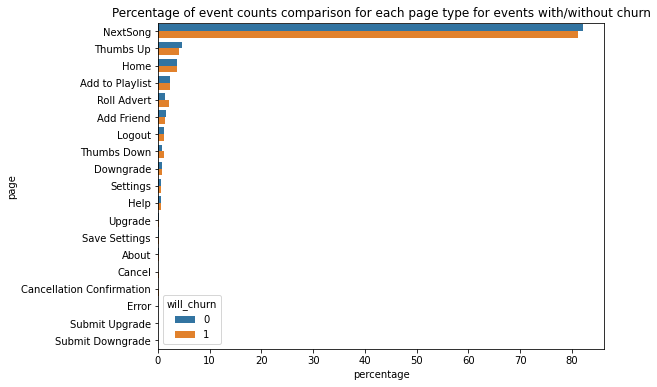

In [25]:
# Creating a comparison plot visualizing the difference between the percentages of each page type by churn
plt.figure(figsize=(8,6))

sns.barplot(x='percentage', y='page', hue='will_churn', data=pd_churn_page);
plt.title("Percentage of event counts comparison for each page type for events with/without churn");

### We will go ahead to analyse the number of songs played in each hour in the events of not churned and churned users


In [26]:
# Firsty, we create an hour column by calculating Static hour using the 'ts' column
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)
df = df.withColumn('hour', get_hour('ts'))

In [27]:
def plot_NumberOfSongsInHour(will_churn):
    '''
    Plot a number of songs in hour for events with the specified churn value
    '''
    
    # Get a number of songs in hour for a particular data set
    songs_in_hour = df.filter(df.will_churn == will_churn) \
        .groupby('hour') \
        .count() \
        .orderBy(df.hour.cast("float"))

    
    # Convert to pandas and create a scatter plot

    pd_songs_in_hour = songs_in_hour.toPandas()
    pd_songs_in_hour.hour = pd.to_numeric(pd_songs_in_hour.hour)

    plt.scatter(pd_songs_in_hour["hour"], pd_songs_in_hour["count"]);
    plt.xlim(-1, 24);
    plt.ylim(0, 1.2 * pd_songs_in_hour["count"].max())
    plt.xlabel("Hour")
    plt.ylabel("Songs played");

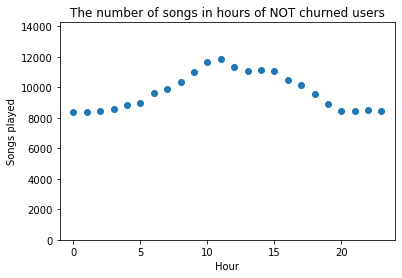

In [28]:
# Visualizing the number of songs in hours of events of not churned users
plot_NumberOfSongsInHour(0)
plt.title('The number of songs in hours of NOT churned users');

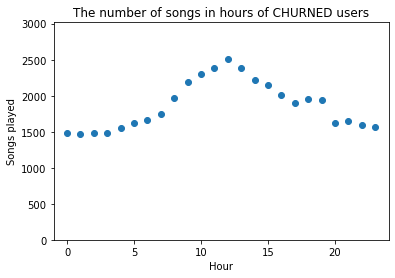

In [29]:
# Visualizing he number of songs in hours of events of churned users
plot_NumberOfSongsInHour(1)
plt.title('The number of songs in hours of CHURNED users');

From the visualizations, there seems to be a similar trend between a number of songs played in each hour of events of users who are churned and who are not churned

### Now lets understand how gender plays a factor in churn rate  

In [30]:
#selecting a subset of the data 

df_gender = df.select("userId", "gender", 'will_churn') \
    .dropDuplicates() \
    .groupby('will_churn', 'gender') \
    .count() 

In [31]:
df_gender.orderBy('will_churn', 'gender').show()

+----------+------+-----+
|will_churn|gender|count|
+----------+------+-----+
|         0|     F|   84|
|         0|     M|   89|
|         1|     F|   20|
|         1|     M|   32|
+----------+------+-----+



In [32]:
#conerting to a pandas dataframe for visualization 
pd_gender = df_gender.toPandas()

In [33]:
#creating a pivot table 
pd_gender_pivot = pd_gender.pivot(index='will_churn', columns='gender', values='count')
total_counts = pd_gender_pivot.sum(axis=1)
pd_gender_pivot = pd_gender_pivot.div(total_counts, axis=0)
pd_gender_pivot

gender,F,M
will_churn,,
0,0.485549,0.514451
1,0.384615,0.615385


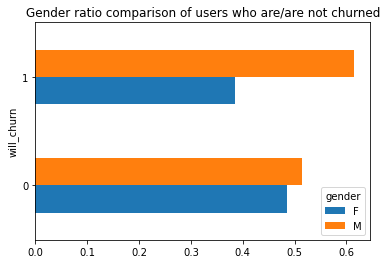

In [34]:
pd_gender_pivot.plot.barh();
plt.title('Gender ratio comparison of users who are/are not churned');

From the analysis and visualization, we see that it is more likely for a male customer to be churned than a female

### Analysis of session time spent by users on the platform

In [35]:
# Selecting data based on churn status
df_churn = df.filter('will_churn == 1')
df_not_churn = df.filter('will_churn == 0')

In [36]:
def get_session_time(df, showSummary=False):
    '''
    Get number of registration days of the dataset
    
    Input: Sparkify dataset
        
    Optional Input:
        showSummary: Show summary statistics of the output data fram. Default is False.
        
    Output:
        df_sessionTime: Spark dataframe contains sessionTime information of each userId and sessionId
    '''
    
    # Find a session time by grouping events by userId and sessionId
    # and then find a difference between the min and max timestamp
    df_sessionTime = df.groupby("userId", "sessionId") \
        .agg(((max(df.ts)-min(df.ts))/(1000*60)) \
        .alias("sessionTime"))
    
    if showSummary:
        # Print the statistics
        df_sessionTime.select('sessionTime').describe().show();

        # Create a box plot
        df_sessionTime.select('sessionTime').toPandas().boxplot();
    
    return df_sessionTime;
    

+-------+------------------+
|summary|       sessionTime|
+-------+------------------+
|  count|               537|
|   mean|283.12153941651167|
| stddev| 375.3192516301638|
|    min|               0.0|
|    max| 3300.016666666667|
+-------+------------------+



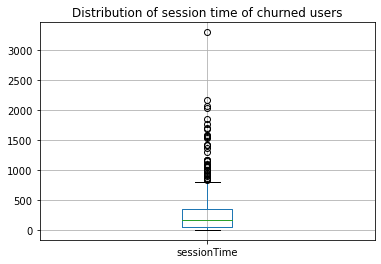

In [37]:
#Session time of churned users
df_sessionTime_churn = get_session_time(df_churn, showSummary=True)
plt.title('Distribution of session time of churned users');

+-------+-----------------+
|summary|      sessionTime|
+-------+-----------------+
|  count|             2639|
|   mean|302.8553618794994|
| stddev|393.2417448405118|
|    min|              0.0|
|    max|4455.083333333333|
+-------+-----------------+



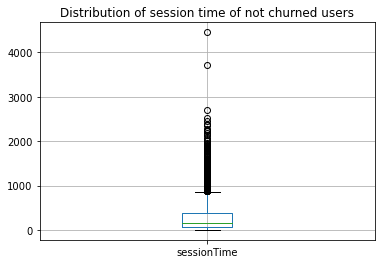

In [38]:
#Session time of not churned users
df_sessionTime_not_churn = get_session_time(df_not_churn, showSummary=True)
plt.title('Distribution of session time of not churned users');

The statistics of session time shows that:

* The average session time of churned users is approximately: 283 minutes/session
* The average session time of not churned users is approximately: 302 minutes/session

### Analysis number of songs per session for each user group

In [39]:
def get_songs_per_session(df, showSummary=False):
    '''
    Get a number of songs played in each userId and sessionId
    
    Input:
        df: Sparkify dataframe
        
    Optional Input:
        showSummary: Show summary statistics of the output data fram. Default is False.
        
    Output:
        df_songs_per_session: Spark dataframe contains information of each userId and sessionId
    '''
    
    # Filter only events with the "NextSong" page
    # Then, group them by userId and sessionId and find the counts
    df_songs_per_session = df.filter(df.page=="NextSong") \
        .groupby("userId", "sessionId") \
        .count()
    
    if showSummary:
        # Print the statistics
        df_songs_per_session.select('count').describe().show();

        # Create a box plot
        df_songs_per_session.select('count').toPandas().boxplot();
    
    return df_songs_per_session;

+-------+-----------------+
|summary|            count|
+-------+-----------------+
|  count|              519|
|   mean| 70.1233140655106|
| stddev|88.76147060464496|
|    min|                1|
|    max|              708|
+-------+-----------------+



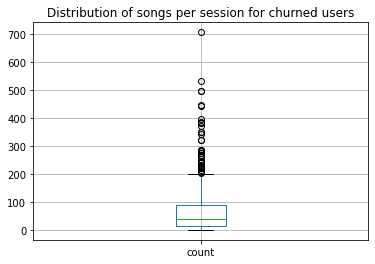

In [40]:
#Songs per session for churned users 
df_songs_per_session_churn = get_songs_per_session(df_churn, showSummary=True);
plt.title('Distribution of songs per session for churned users');

+-------+----------------+
|summary|           count|
+-------+----------------+
|  count|            2552|
|   mean|75.1230407523511|
| stddev|94.2792988298564|
|    min|               1|
|    max|            1093|
+-------+----------------+



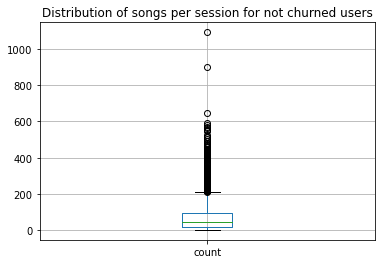

In [41]:
#Songs per session for not churned users 
df_songs_per_session_not_churn = get_songs_per_session(df_not_churn, showSummary=True)
plt.title('Distribution of songs per session for not churned users');

The statistics of session time shows that:

* The average songs played in each session by churned users is approximately 70 songs
* The average songs played in each session by not churned users is approximately 75 songs

### Analysis of registration days

In [42]:
def get_user_reg_days(df, showSummary=False):
    '''
    Get a number of registration days 
    
    Input:
        df:   Sparkify dataframe
        
    Optional Input:
        showSummary: Show summary statistics of the output data fram. Default is False.
        
    Output:
        user_reg_days: Spark dataframe contains information of a number of registration days
    '''
    
    # Get a max timestamp of each ID first
    user_max_ts = df.groupby("userId").max("ts").sort("userId")

    # Get the registration timestamp. 
    user_reg_ts = df.select("userId", "registration").dropDuplicates().sort("userId")

    # Join the max timestamp and registration timestamp table
    join_reg_max_ts = user_reg_ts.join(user_max_ts, (user_reg_ts.userId == user_max_ts.userId))

    # Then, select
    # 1) The userId column
    # 2) Computed a number of registration days from the max and registration columns
    user_reg_days = join_reg_max_ts.select(user_reg_ts["userId"], 
                                           ((user_max_ts["max(ts)"]-user_reg_ts["registration"])/(1000*60*60*24))
                                            .alias("NumRegDays"))
    
    if showSummary:
        # Print the statistics
        user_reg_days.select('NumRegDays').describe().show();

        # Create a boxplot of the statistics
        user_reg_days.select('NumRegDays').toPandas().boxplot();

    return user_reg_days

+-------+-----------------+
|summary|       NumRegDays|
+-------+-----------------+
|  count|               52|
|   mean|57.30599292200855|
| stddev| 36.6331481313374|
|    min|5.165115740740741|
|    max|188.3117824074074|
+-------+-----------------+



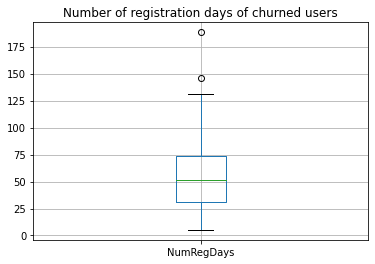

In [43]:
# Registration days and statistics of churned users
user_reg_days = get_user_reg_days(df_churn, showSummary=True)
plt.title('Number of registration days of churned users');

+-------+-------------------+
|summary|         NumRegDays|
+-------+-------------------+
|  count|                173|
|   mean|  86.62061938021833|
| stddev|  35.34864197873643|
|    min|0.31372685185185184|
|    max|  256.3776736111111|
+-------+-------------------+



Text(0.5, 1.0, 'Number of registration days of not churned users')

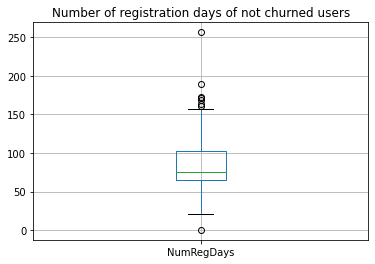

In [44]:
# Registration days and statistics of not churned users
user_reg_days = get_user_reg_days(df_not_churn, showSummary=True)
plt.title('Number of registration days of not churned users')

The analysis shows that :
* The number of registration days of churned users are an average of 57 days
* The number of registration days of not churned users are an average of 86 days

### Analysis of user level

In [45]:
def get_user_level(df, showSummary=False):
    '''
    Get data of the last user level (paid/free) 
    
    Input:
        df: Sparkify dataframe
    
    Optional Input:
        showSummary: Show summary statistics of the output data fram. Default is False.
        
    Output:
        user_reg_days: Spark dataframe contains data of the last user level (paid/free) of a given data
    '''
    
    # Get a max timestamp of each ID first
    user_max_ts = df.groupby("userId").max("ts").sort("userId")

    # Get the registration timestamp. 
    user_level = df.select("userId", "level").dropDuplicates()
    
    
    if showSummary:
        # show a summary of counts grouped by 'level' 
        total_user_level = user_level.count()

        group_level = user_level.groupby('level').count()
        get_ratio = udf(lambda x: x*1.0/total_user_level, FloatType())
        df_level = group_level.withColumn('ratio', get_ratio("count"))
        df_level.show()
    
    return user_level;

In [46]:
# Number of user level of churned users
get_user_level(df_churn, showSummary=True)

+-----+-----+---------+
|level|count|    ratio|
+-----+-----+---------+
| free|   46|0.5609756|
| paid|   36|0.4390244|
+-----+-----+---------+



DataFrame[userId: string, level: string]

In [47]:
# Number of user level of not churned users
get_user_level(df_not_churn, showSummary=True)

+-----+-----+----------+
|level|count|     ratio|
+-----+-----+----------+
| free|  149| 0.5359712|
| paid|  129|0.46402878|
+-----+-----+----------+



DataFrame[userId: string, level: string]

The analysis shows that a ratio of free/paid users who are/are not churned are similar (around 55/45)

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

Based on the Exploratory Data Analysis (EDA), we will create features that will be used to train our model from the folllowing:

* Gender 
* Average session time 
* Average number of songs played in each session 
* User registration
* User level 

#### User Gender 

In [48]:
# Dropping duplicates 
df_gender = df.dropDuplicates(['userId']).sort('userId').select(['userId','gender'])

# Creating index for gender using StringIndexerModel  

fromlabelsModel = StringIndexerModel.from_labels(["F", "M"], \
    inputCol="gender", outputCol="gender_index", handleInvalid="error")
df_gender = fromlabelsModel.transform(df_gender)

# Only extracted interested columns
df_gender = df_gender.select('userId', df_gender.gender_index.cast("int"))
df_gender.head()

Row(userId='10', gender_index=1)

#### Average session time 

In [49]:
def scale_column_with_StandardScaler(df, column_name):
    '''
    Scale column using the StandardScaler
    
    Input :
        df:Spark dataframe
        column_name:  Column name with numerical value to be scaled with the StandardScaler
    
    Output :
        df_scaled: New Spark dataframe with the "_vec" and "_scaled" columns
    '''
    
    # Creating a vector of sessionTime first before scaling 
    column_vec = column_name + '_vec'
    assembler = VectorAssembler(inputCols=[column_name], outputCol=column_vec)
    df_scaled = assembler.transform(df)

    # Using the StandardScale to scale the session time
    column_scaled = column_name + '_scaled'
    scaler = StandardScaler(inputCol=column_vec, 
                            outputCol=column_scaled, 
                            withStd=True)

    # Selecting only the interested columns
    df_scaled = scaler.fit(df_scaled).transform(df_scaled)
    
    return df_scaled;

In [50]:
def get_avg_column_by_user(df, column_name):
    '''
    Get average values of a particular column grouped by userId
    
    Input:
    df : Sparkify dataframe
    column_name: The interested column name that we want to get average values for
    
    Output :
    df_avg: Spark dataframe with average values information stored in a column "avg_""
    '''
    df_avg = df.groupby('userId') \
                .agg(avg(column_name)) \
                .select('userId', col('avg(' + column_name + ')').alias('avg_' + column_name))
    
    return df_avg

In [51]:
# Getting the average session time 
df_sessionTime = get_session_time(df)
df_sessionTime_avg = get_avg_column_by_user(df_sessionTime, 'sessionTime')
df_sessionTime_avg.show()

+------+------------------+
|userId|   avg_sessionTime|
+------+------------------+
|100010|154.48333333333332|
|200002|266.40000000000003|
|   125|29.566666666666666|
|    51| 872.3566666666666|
|   124| 578.9942528735633|
|     7| 87.64047619047619|
|    54|322.28963963963963|
|    15| 528.2833333333333|
|   155| 548.5722222222222|
|100014| 184.8138888888889|
|   132|498.95104166666675|
|   154|110.68333333333332|
|   101| 817.5800000000002|
|    11|161.37708333333333|
|300017|233.32407407407408|
|   138| 564.2266666666667|
|    29| 365.7568627450981|
|    69| 526.6851851851852|
|100021| 215.2266666666667|
|    42|329.56276595744686|
+------+------------------+
only showing top 20 rows



In [52]:
# Scaling
df_sessionTime_avg_scaled = scale_column_with_StandardScaler(df_sessionTime_avg, 'avg_sessionTime')
df_sessionTime_avg_scaled = df_sessionTime_avg_scaled.select('userId', 'avg_sessionTime_scaled')
df_sessionTime_avg_scaled.show()

+------+----------------------+
|userId|avg_sessionTime_scaled|
+------+----------------------+
|100010|  [0.8735647913871122]|
|200002|  [1.5064256797423243]|
|   125|   [0.167192139380811]|
|    51|   [4.932959776880936]|
|   124|  [3.2740683594292666]|
|     7|  [0.4955850747679395]|
|    54|  [1.8224676781833815]|
|    15|   [2.987310733908436]|
|   155|   [3.102039349657914]|
|100014|   [1.045076532264515]|
|   132|  [2.8214439268049896]|
|   154|  [0.6258866953934418]|
|   101|   [4.623211363527513]|
|    11|  [0.9125472314386275]|
|300017|  [1.3193895528802007]|
|   138|  [3.1905613358186153]|
|    29|  [2.0682640036831996]|
|    69|  [2.9782736039895066]|
|100021|  [1.2170532193393693]|
|    42|   [1.863595396866394]|
+------+----------------------+
only showing top 20 rows



#### Average number of songs played in each session 

In [53]:
# Getting data of number of songs per session
df_song = get_songs_per_session(df)

In [54]:
# Getting average number of songs per session for each user
df_song_avg = get_avg_column_by_user(df_song, 'count')
# Renaming the column 
df_song_avg = df_song.select('userId', col('count').alias('num_songs'))

In [55]:
# Scaling 'num_songs' column with StandardScaler
df_song_avg_scaled = scale_column_with_StandardScaler(df_song_avg, 'num_songs')

# Selecting userId and the scaled column
df_song_avg_scaled = df_song_avg_scaled.select('userId', 'num_songs_scaled')

#Results
df_song_avg_scaled.show()

+------+--------------------+
|userId|    num_songs_scaled|
+------+--------------------+
|    92|[0.6104453670311931]|
|    42|[0.17135308548244...|
|   101| [7.582374032597977]|
|   120|[2.5274580108659923]|
|   140|[0.03212870352795...|
|   122|[0.06425740705591...|
|    29|[0.13922438195448...|
|     8|[0.11780524626917...|
|    96|[1.4243725230727837]|
|   153|[0.6639932062444556]|
|    97|[0.7496697489856757]|
|    35|[0.10709567842652...|
|   110|[0.19277222116774...|
|300011|[0.28915833175161...|
|   137|[0.06425740705591...|
|    40|[0.6532836384018031]|
|    35|[0.13922438195448...|
|    24|[0.05354783921326...|
|    47|[0.03212870352795...|
|    85|[0.7817984525136332]|
+------+--------------------+
only showing top 20 rows



#### User registration timeline

In [56]:
# Getting number of days since each user registered
df_reg_days = get_user_reg_days(df)

# Scaling with StandardScaler
df_reg_days_scaled = scale_column_with_StandardScaler(df_reg_days, 'NumRegDays')
df_reg_days_scaled = df_reg_days_scaled.select('userId', 'NumRegDays_scaled').sort('userId')

#Results
df_reg_days_scaled.show(5)

+------+--------------------+
|userId|   NumRegDays_scaled|
+------+--------------------+
|    10|[1.3744192788380685]|
|   100|[1.7225502115580493]|
|100001|[1.1895504844942821]|
|100002| [4.260908341600925]|
|100003|[0.6040155473135719]|
+------+--------------------+
only showing top 5 rows



#### User level (free or paid) 

In [57]:
# Getting data of user level
df_level = get_user_level(df)

# Transforiming the selected data
fromlabelsModel = StringIndexerModel.from_labels(["free", "paid"],
    inputCol="level", outputCol="level_index", handleInvalid="error")
df_level = fromlabelsModel.transform(df_level)

# Subsetting columns
df_level = df_level.select('userId', df_level.level_index.cast("int"))

#Results
df_level.show(5)

+------+-----------+
|userId|level_index|
+------+-----------+
|100021|          0|
|200021|          0|
|200001|          0|
|     6|          0|
|300022|          1|
+------+-----------+
only showing top 5 rows



Now we are going to join the scaled data columns with the churn dataframe using the 'userId' column

In [58]:
# Create the label (churn) data 
df_combined = df.dropDuplicates(['userId']) \
                .sort('userId') \
                .select(['userId', col('will_churn').alias('label').cast("int")])

In [59]:
# Iterating through each data frame that we created earlier and joining them with the label dataframe
feature_list = [    
    df_gender, 
    df_sessionTime_avg_scaled, 
    df_song_avg_scaled, 
    df_reg_days_scaled, 
    df_level
]

for feature in feature_list:
    df_combined = df_combined.join(feature,'userId')

In [60]:
# Inspect the schema of the combined data frame 
df_combined.printSchema()

root
 |-- userId: string (nullable = true)
 |-- label: integer (nullable = true)
 |-- gender_index: integer (nullable = true)
 |-- avg_sessionTime_scaled: vector (nullable = true)
 |-- num_songs_scaled: vector (nullable = true)
 |-- NumRegDays_scaled: vector (nullable = true)
 |-- level_index: integer (nullable = true)



Moving on, we are going to create a dataframe that will be used for modeling by

* Combining values in the feature columns into a single DenseVector and naming it 'features'
* Creating a data frame 'df_final' consisting of only 'features' and 'label' columns

In [61]:
assembler = VectorAssembler(inputCols=df_combined.columns[2:-1], outputCol="features")
df_combined = assembler.transform(df_combined)
df_combined.head()

Row(userId='10', label=0, gender_index=1, avg_sessionTime_scaled=DenseVector([2.5998]), num_songs_scaled=DenseVector([4.0803]), NumRegDays_scaled=DenseVector([1.3744]), level_index=1, features=DenseVector([1.0, 2.5998, 4.0803, 1.3744]))

In [62]:
df_final = df_combined.select('features', 'label')
df_final.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[0.0,0.8735647913...|    0|
|[0.0,0.8735647913...|    0|
|[0.0,0.8735647913...|    0|
|[0.0,0.8735647913...|    0|
|[0.0,0.8735647913...|    0|
+--------------------+-----+
only showing top 5 rows



In [63]:
df_final.persist()

DataFrame[features: vector, label: int]

We started by selecting userId and each feature and then went ahead to transform the colums depending on the type of variables, i.e- StringIndexerModel was used to transform categorical variables into numberical, VectorAssembler and StandardScaler were used to transform numerical variables into a numeric variables with a unit variance.

After getting the dataframe of userId and transformed data of each feature, we carried out a join of all the data frames based on the userId columns. We combined all feature values into a vector and generated a final data frame which contains of only two columns; 'features' and 'label'.This dataframe will proove essentially useful in the Modeling step next. 

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [64]:
#splitting the data into train and test set
train, test = df_final.randomSplit([0.8, 0.2], seed=10)

For this, we are going to make use of three different models: logistic regression, svm and gradient boosting tree

In [67]:
log = LogisticRegression(maxIter=10,regParam=0.0)
gbt = GBTClassifier(maxDepth=5,maxIter=10,seed=20)
svm = LinearSVC(maxIter=10, regParam=0.01)

#### Logistic Regression

In [75]:
#Logistic Regression
e1 = MulticlassClassificationEvaluator(metricName='f1')
paramGrid = ParamGridBuilder().addGrid(log.regParam,[0.0, 0.05, 0.1]).build()
crossval = CrossValidator(estimator=log,
                          estimatorParamMaps=paramGrid,
                          evaluator=e1,
                          numFolds=3)

In [77]:
#fit with the train set
cvModel_q1 = crossval.fit(train)

#report the f1 score 
cvModel_q1.avgMetrics

[0.7641149436327447, 0.7534223223015224, 0.7534223223015224]

In [78]:
# Get predicted value of the test set
results_q1 = cvModel_q1.transform(test)

In [79]:
# Checking accuracy of the results
print(results_q1.filter(results_q1.label == results_q1.prediction).count())
print(results_q1.count())

885
1055


In [80]:
print('Accuracy of the best LogisticRegression model: {}'.format((885/1055)*100.))

Accuracy of the best LogisticRegression model: 83.88625592417061


Using BinaryClassificationEvaluator to find the area under ROC



In [81]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
evaluator.getMetricName()
evaluator.evaluate(results_q1)

0.7073533672206274

In [82]:
# Save the model
cvModel_q1.bestModel.save('logistic.model')

#### Support Vector Machine 

In [83]:
#Support Vector Machine
e2 = MulticlassClassificationEvaluator(metricName='f1')
paramGrid = ParamGridBuilder().addGrid(svm.regParam,[0.01, 0.05, 0.5]).build()
crossval = CrossValidator(estimator=svm,
                          estimatorParamMaps=paramGrid,
                          evaluator=e2,
                          numFolds=3)

In [84]:
#fit with the train set
cvModel_q2 = crossval.fit(train)

#report the f1 score 
cvModel_q2.avgMetrics

[0.7534223223015224, 0.7534223223015224, 0.7534223223015224]

In [85]:
# Get predicted value of the test set
results_q2 = cvModel_q2.transform(test)

In [86]:
# Checking accuracy of the results
print(results_q2.filter(results_q2.label == results_q2.prediction).count())
print(results_q2.count())

883
1055


In [87]:
print('Accuracy of the best SVM model: {}'.format((883/1055)*100.))

Accuracy of the best SVM model: 83.69668246445498


Using BinaryClassificationEvaluator to find the area under ROC

In [88]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
evaluator.getMetricName()
evaluator.evaluate(results_q2)

0.6981484895572702

In [89]:
# Save the model
cvModel_q2.bestModel.save('svm.model')

#### Gradient Boosted Tree Models 

In [90]:
e3 = MulticlassClassificationEvaluator(metricName='f1')
paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth,[5, 10]) \
    .build()
crossval = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=e3,
                          numFolds=3)

In [91]:
#fit with the train set
cvModel_q3 = crossval.fit(train)

#report the f1 score 
cvModel_q3.avgMetrics

[0.9553832286452998, 0.9875652192353693]

In [92]:
# Get predicted value of the test set
results_q3 = cvModel_q3.transform(test)

In [93]:
# Checking accuracy of the results
print(results_q3.filter(results_q3.label == results_q3.prediction).count())
print(results_q3.count())

1045
1055


In [94]:
print('Accuracy of the best GBT model: {}'.format((1045/1055)*100.))

Accuracy of the best GBT model: 99.0521327014218


Using BinaryClassificationEvaluator to find the area under ROC

In [95]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
evaluator.getMetricName()
evaluator.evaluate(results_q3)

0.9983736732597646

In [103]:
# Save the model
cvModel_q3.bestModel.save('gbt.model')

### Conclusion


In this modelling section, we used Spark to build Machine Learning models in conjunction with CrossValidator and ParamGridBuilder to tune hyper parameters to find the best model.
Among the three models we've been trained:

* logistic regression (best f1 score 0.7641) (Accuracy of the best Logistic model: 83.88%)
* Support Vector Machine (best f1 score 0.7534) (Accuracy of the best SVM model: 83.69%)
* Graident Boosted Tree (best f1 score 0.7621 ) (Accuracy of the best GBT model: 99.05%)



Based on the results, the best model is the GBTClassifier which out performs the best model  from the LogisticRegression and the SVM model in terms of accuracy and area under ROC however,  more time was spent training the GBTClassifier model.


### Summary 

In this project, we were able to study the Sparkify streaming service dataset and created models to predict customer churn after carrying out feature engineering. We started by exploring the data that we have and trying to understand the different levels of the dataset and how it impacted churn. We then went ahead to create features that were later used in build three machine(GBT). Amongst the three models, the GBT performed best with good f1 scores and hight accuracy score of 99% although it took a longer time to train.





### Future Improvement


1. For the feature engineering process, we operated using procedure programming hence, we would need to reimplement the same logic when doing a similar task. In essence, the feature engineering process is not very efficient in terms of time saving. What can be done to improve this is to create a class or build a pipeline to perform the feature engineering process. This way we will be able to utilize the same code for similar tasks and when deploying in different environments.

2. We used a small subset of the data (128MB) to train the Machine Learning models to predict churn is and this contains only a small number of users who are churned. There may be a different pattern or different performance metrics if the Machine Learning model is trained with a large dataset (12GB)

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.